In [506]:
###################
#インポート
###################

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


【シンプルデータセット3】
len(X):100


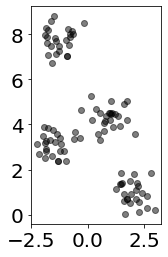

In [507]:
###################
#シンプルデータセット3
###################

from sklearn.datasets import make_blobs
X, _ = make_blobs(n_samples=100, n_features=2, centers=4, cluster_std=0.5, shuffle=True, random_state=0)

print("【シンプルデータセット3】")
#print("X.shape:{}".format(X.shape)) #------検証中--------
print("len(X):{}".format(len(X))) #------検証中--------

#----散布図の描画----
p = plt.subplot()
p.scatter(X[:,0], X[:,1], c = "black", alpha = 0.5)
p.set_aspect('equal')
plt.show()


【テストデータ】
X_train.shape:(70, 2)


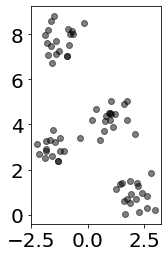

In [508]:
###################
#データの分割
###################
X_train, X_test = train_test_split(X, test_size=0.3, random_state=0, shuffle=True)

print("【テストデータ】")
print("X_train.shape:{}".format(X_train.shape)) #------検証中--------

#----散布図の描画----
p = plt.subplot()
p.scatter(X_train[:,0], X_train[:,1], c = "black", alpha = 0.5)
p.set_aspect('equal')
plt.show()




In [509]:
###################
#ScratchKMeansクラス
###################

#クラスタリングのスクラッチ
class ScratchKMeans():

    def __init__(self, n_clusters=2,n_init=20,n_iter=100,verbose=False):
        """
        パラメータ
        n_clusters : クラスタ数
        n_init : 何回初期化するか #初期かってなに？
        max_iter : 各初期化毎に何回学習させるか
        verbose : 学習状況を出力するか否か

         ----------

        """
        self.n_clusters = n_clusters#区分けグループ数
        self.n_init = n_init
        self.n_iter = n_iter#イテレーション回数
        self.verbose = verbose#学習仮定の出力
        # SSE（誤差）を小さくする方向に学習（更新）させていくため、初期値は大きいものを用意しておく
        self.best_sse = 10**20



#-----【問題1】クラスタの中心点myuの初期値を決める-----
    #クラスタの中心点ndarrayであるmyuの定義とmyuの初期値設定
    def _update_myu(self,X):
            """中心点の更新
            Parameters
            ----------
            X : 説明変数
            """
            self.pre_myu = self.myu #★☆★☆これ何で書けたの？self.pre_myu is not difine にならないの
            np.sum(self.pre_myu)



            # self.myuの初期値及び一般式を決める。XのX[:,0]とX[:,1]の平均値をself.myuの初期値とする
            # クラスタの回数繰り返す
            # ここで入力されているXはすでに[:,-1]にクラスタ番号がついている。X[:,-1]はクラスタ番号のこと
            for j in range(self.n_clusters):

                #★☆★☆X[X[:,-1]==j,:-1]は例えばｊが０の時、X[:,-1]==jのクラスタ番号が０の時の、、、
                self.myu[j] = np.mean(X[   X[:,-1]==j   ,   :-1   ],axis=0) #これ何表していますか？:-1 はクラスタ以外を表す

            return self.myu #Xのクラスタ番号が決まっていて、そのクラスタ番号の平均値が入っているself.myu



    #すべてのデータ点Xを最も近い中心点myu(1.2.3....Kのどれか）に割り当てるコード
    def _update_cluster(self,X):
        """クラスタの更新　Xデータのクラスタを全て更新する
        Parameters
        ----------
        X : 説明変数
        """


        # データ数でループ
        for i in range(len(X)):

            # 比較のための初期値
            dist_m = 10**20#この値は適当

            # クラスタ数でループ
            for j in range(self.n_clusters):

                # 該当クラスタの中心点との距離を計算
                #(X[i,:-1]-self.myu[j])この計算のイメージをもっていなかった
                dist = np.sqrt(np.sum((X[i,:-1]-self.myu[j])**2)) #★☆★☆X[i,:-1]ここ図書いて聞く　

                # 前回保存した（あるいは初期値）より距離が小さければ、そちらのクラスタを採用
                #そのi番目のデータのクラスタ
                if dist < dist_m:
                    dist_m = dist
                    X[i,-1] = j #Xの最後の列に一番近かったクラスタの番号を入れている
        #print("X:{}".format(X)) #------検証中--------

        return X

    #-----【問題2】SSEを求める関数の作成-----

    def calc_sse(self,X):
        """
        Xのデータ全部とクラスタの中心値myuの距離をピタゴラスの定理から求めて一番小さい距離とクラスタ番号を記録する
        ここでのXはクラスタ番号が入っている
        Parameters
        ----------
        X : 説明変数
        """
        # SSEの計算
        sse = 0

        # データ数でループ
        for i in range(len(X)):

            # クラスタ数でループ
            for j in range(self.n_clusters):

                # 末尾のクラスタを判定し、該当クラスタならsseに加算　★☆★☆ってどういうこと？
                # X[i,-1]は

                if j == X[i,-1]:#-1の末尾のところにクラスタが入っているのでiでforして該当クラスタならΣなのでSamする
                    # ベクトルの距離（ノルム）計算＊末尾のクラスタを除いた数値を使用している点に注意
                    sse += np.sum((X[i,:-1]-self.myu[j])**2)

        # sseが改善していれば、更新
        if self.best_sse > sse:
            self.best_sse = sse
            self.record_myu = self.myu
            self.record_cluster = self.n_clusters


        return self.record_myu



    #クラスタの中心値myuの初期値を決める。
    def fit(self, X):

        #np.random.choice(取り出す配列, 取り出す数, replace：重複OKか)
        self.myu = X[np.random.choice(len(X),size=self.n_clusters,replace=False)]# myuの数量はXの列数と同じになる

        print("myu.shape:{}".format(self.myu.shape)) #------検証中--------
        print("myu:{}".format(self.myu)) #------検証中--------
        print("len(myu):{}".format(len(self.myu))) #------検証中--------


        # Xベクトルにクラスタ列を追加（クラスタは0で初期化）
        cluster = np.zeros(len(X))
        X_cluster = np.concatenate([X,cluster.reshape(-1,1)],axis=1)
        print("X_cluster.shape:{}".format(X_cluster.shape)) #------検証中--------

        # イテレーション回数forする
        for j in range(self.n_iter):
            # SSEを更新
            #calc_sseはSSEを求めるメソッド,
            #X_clusterはXにmyu（クラスタの値）を追加した配列
            self.record_myu = self.calc_sse(X_cluster) #Xのデータ全部とクラスタの中心値myuの距離をピタゴラスの定理から求めて一番小さい距離とクラスタ番号を記録する


            # クラスタ更新
            X = self._update_cluster(X_cluster) #すべてのデータ点Xを最も近い中心点myu(1.2.3....Kのどれか）に割り当てるコード

            # クラスタの中心点の更新
            self._update_myu(X_cluster)

            # 学習状況の出力（グラフ）
            # if self.verbose:
            #     print("初期化：%s　学習回数：%s　最善のSSE：%s"%(i,j,self.best_sse))
        return self.record_myu,X

    def predict(self, X):
        """予測
        Parameters
        ----------
        X : 説明変数
        """
        # 予測値の初期化
        y_pred = np.zeros(len(X))
        # 処理の流れ自体は、_reclustering関数と同様
        # データ数でループ
        for i in range(len(X)):
            # 比較のための初期値
            dist_m = 10**20
            # クラスタ数でループ
            for j in range(self.record_cluster):
                # 該当クラスタの中心点との距離を計算
                dist = np.sqrt(np.sum((X[i]-self.record_myu[j])**2))
                # 前回保存した（あるいは初期値）より距離が小さければ、そちらのクラスタを採用
                if dist < dist_m:
                    dist_m = dist
                    y_pred[i] = j
        return y_pred



myu.shape:(4, 2)
myu:[[ 1.24016835  1.12905479]
 [-2.27253281  3.13757811]
 [ 0.3498724   4.69253251]
 [ 2.79939362  1.84560825]]
len(myu):4
X_cluster.shape:(70, 3)
record_myu:[[ 2.06105512  0.8798154 ]
 [-1.54350374  2.96501555]
 [-1.23920571  7.73872714]
 [ 1.04710036  4.30842418]]


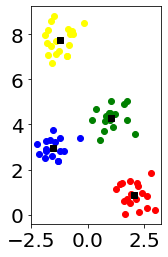

In [510]:
#----clf　インスタンス化------

clf = ScratchKMeans(n_clusters=4,n_init=5,n_iter=15,verbose=True)

record_myu,X = clf.fit(X_train)
print("record_myu:{}".format(record_myu)) #------検証中--------

#----散布図の可視化------ここ色を勝手に増やすことはできますか？

p = plt.subplot()

p.scatter(X[X[:,2]==0, 0], X[X[:,2]==0, 1], c = 'red')
p.scatter(X[X[:,2]==1, 0], X[X[:,2]==1, 1], c = 'blue')
p.scatter(X[X[:,2]==2, 0], X[X[:,2]==2, 1], c = 'yellow')
p.scatter(X[X[:,2]==3, 0], X[X[:,2]==3, 1], c = 'green')
# 中心点
p.scatter(record_myu[:, 0], record_myu[:, 1], color='black', marker='s')

p.set_aspect('equal')

plt.show()


myu.shape:(6, 2)
myu:[[ 1.19820169  4.47062449]
 [-1.33869125  2.36818187]
 [-1.8219901   7.61654999]
 [ 1.51989121  1.42488952]
 [ 0.72086751  3.71347124]
 [ 1.73810647  0.71629308]]
len(myu):6
X_cluster.shape:(70, 3)
record_myu:[[ 1.16986717  4.42992382]
 [-1.62404855  2.93667512]
 [-1.23920571  7.73872714]
 [ 1.88943043  1.41824774]
 [ 0.27180856  3.65359988]
 [ 2.17027084  0.53717664]]


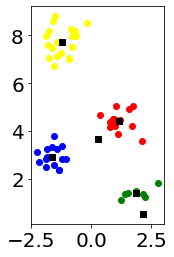

In [511]:
#-----【問題6】異なる初期値で計算-----

#----clf2　インスタンス化------

clf2 = ScratchKMeans(n_clusters=6,n_init=5,n_iter=20,verbose=True)

record_myu,X = clf2.fit(X_train)
print("record_myu:{}".format(record_myu)) #------検証中--------

#----散布図の可視化------

p = plt.subplot()

p.scatter(X[X[:,2]==0, 0], X[X[:,2]==0, 1], c = 'red')
p.scatter(X[X[:,2]==1, 0], X[X[:,2]==1, 1], c = 'blue')
p.scatter(X[X[:,2]==2, 0], X[X[:,2]==2, 1], c = 'yellow')
p.scatter(X[X[:,2]==3, 0], X[X[:,2]==3, 1], c = 'green')
# 中心点
p.scatter(record_myu[:, 0], record_myu[:, 1], color='black', marker='s')

p.set_aspect('equal')

plt.show()


In [512]:
#-----【問題7】異なる初期値で計算-----
y_pred = clf.predict(X_test)
print("y_pred:{}".format(y_pred))


y_pred:[1. 0. 3. 2. 3. 1. 0. 2. 1. 2. 1. 3. 0. 2. 2. 0. 1. 3. 0. 3. 1. 0. 3. 0.
 2. 3. 1. 3. 1. 1.]


myu.shape:(1, 3)
myu:[[-1.61803727  8.60696731  2.        ]]
len(myu):1
X_cluster.shape:(70, 4)
myu.shape:(2, 3)
myu:[[2.62496786 0.28025075 5.        ]
 [1.89949126 0.92574633 5.        ]]
len(myu):2
X_cluster.shape:(70, 4)
myu.shape:(3, 3)
myu:[[ 1.13280393  3.87673946  0.        ]
 [-0.1666378   8.50372399  2.        ]
 [ 1.72330962  4.2012082   0.        ]]
len(myu):3
X_cluster.shape:(70, 4)
myu.shape:(4, 3)
myu:[[-1.6609057   3.31911046  1.        ]
 [ 1.42002502  1.38236201  3.        ]
 [ 0.78260667  4.15263595  0.        ]
 [ 1.19820169  4.47062449  0.        ]]
len(myu):4
X_cluster.shape:(70, 4)
myu.shape:(5, 3)
myu:[[ 0.5323772   3.31338909  4.        ]
 [-1.87418794  2.84306499  1.        ]
 [ 2.62496786  0.28025075  5.        ]
 [-0.1666378   8.50372399  2.        ]
 [ 1.19820169  4.47062449  0.        ]]
len(myu):5
X_cluster.shape:(70, 4)
myu.shape:(6, 3)
myu:[[ 0.5323772   3.31338909  4.        ]
 [ 0.96217896  4.51795326  0.        ]
 [-1.57006498  6.72375844  2.        

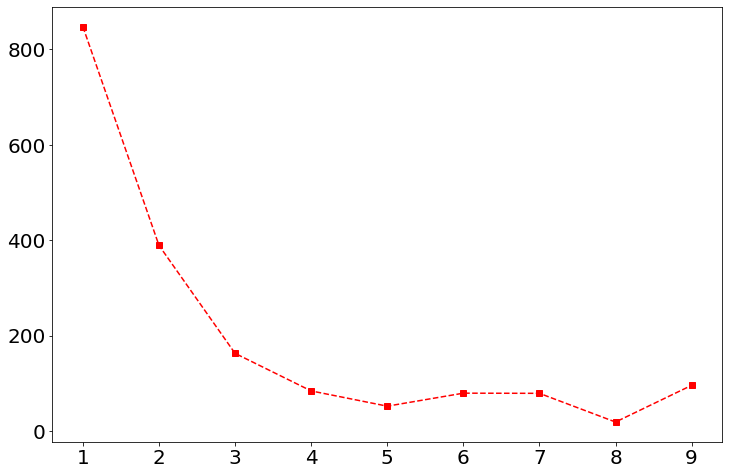

In [513]:
#-----【問題8】エルボー法の実装-----

elbow = {}
for k in range(1,10):
    model = ScratchKMeans(n_clusters=k,n_init=5,n_iter=100,verbose=False)
    model.fit(X)
    elbow[k] = model.best_sse

fig = plt.subplots(figsize=(12,8))
plt.rcParams["font.size"] = 20
plt.plot(list(elbow.keys()),list(elbow.values()),'rs--');


#-----【問題10】クラスタ数kの選択-----

エルボ法からK＝６としました
６つのデータの違いをさらに調べていきたいです。

In [514]:
#-----【問題11】既知のグループとの比較-----

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,12669,9656,7561,214,2674,1338
1,7057,9810,9568,1762,3293,1776
2,6353,8808,7684,2405,3516,7844
3,13265,1196,4221,6404,507,1788
4,22615,5410,7198,3915,1777,5185
...,...,...,...,...,...,...
435,29703,12051,16027,13135,182,2204
436,39228,1431,764,4510,93,2346
437,14531,15488,30243,437,14841,1867
438,10290,1981,2232,1038,168,2125


,Fresh,Milk
0,12669,9656
1,7057,9810
2,6353,8808
3,13265,1196
4,22615,5410
...,...,...
435,29703,12051
436,39228,1431
437,14531,15488
438,10290,1981


myu.shape:(3, 2)
myu:[[  660  8494]
 [39228  1431]
 [11170 10769]]
len(myu):3
X_cluster.shape:(440, 3)
record_myu:[[ 4992  6019]
 [44622 12838]
 [19063  3566]]
X:[[1.2669e+04 9.6560e+03 0.0000e+00]
 [7.0570e+03 9.8100e+03 0.0000e+00]
 [6.3530e+03 8.8080e+03 0.0000e+00]
 ...
 [1.4531e+04 1.5488e+04 2.0000e+00]
 [1.0290e+04 1.9810e+03 0.0000e+00]
 [2.7870e+03 1.6980e+03 0.0000e+00]]


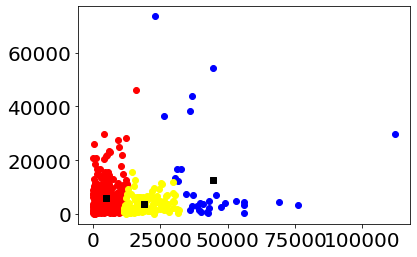

In [515]:
#-----【問題12】卸売業者にとって有益な情報-----
import numpy as np
import pandas as pd

#CSVをインポート
targets_data = pd.read_csv("Wholesale customers data.csv")

#RegionとChannelを削除
targets_data = targets_data.drop(targets_data.columns[[0, 1]], axis=1)
display(targets_data)

#FreshとMilkをスライス
targets_data  = targets_data.loc[ :  ,  [ 'Fresh' ,  'Milk' ] ]
display(targets_data)



#----orosi　インスタンス化------

orosi = ScratchKMeans(n_clusters=3,n_init=5,n_iter=15,verbose=True)

record_myu,X = orosi.fit(targets_data.values)
print("record_myu:{}".format(record_myu)) #------検証中--------
print("X:{}".format(X)) #------検証中--------



#----散布図の可視化------ここ色を勝手に増やすことはできますか？

p = plt.subplot()

p.scatter(X[X[:,2]==0, 0], X[X[:,2]==0, 1], c = 'red')
p.scatter(X[X[:,2]==1, 0], X[X[:,2]==1, 1], c = 'blue')
p.scatter(X[X[:,2]==2, 0], X[X[:,2]==2, 1], c = 'yellow')
p.scatter(X[X[:,2]==3, 0], X[X[:,2]==3, 1], c = 'green')
p.scatter(X[X[:,2]==4, 0], X[X[:,2]==4, 1], c = 'Cyan')
p.scatter(X[X[:,2]==5, 0], X[X[:,2]==5, 1], c = 'Magenta')
# 中心点
p.scatter(record_myu[:, 0], record_myu[:, 1], color='black', marker='s')

p.set_aspect('equal')

plt.show()



#卸売業者にとって有益な情報：FreshとMilkを比べるとFreshのほうがデータの幅が広くクラスタも３つに分かれているので
#それぞれのクラスタごとに提案する商品や広告を変えると良い




つまずいたところ
問題のイメージがわかない
やりたいことがわからない
コードからやりたいことを読み解こうとしたがわからない
何を描けばいいのかわからない

流れを理解するのと、忘れないためにどうすればいいか
defの上と、リターンの後ろに何をしているのかコメントを書く

関数の目的を理解していない、どこで使えばいいのか

In [516]:

x = np.array([[100,0],[200,1],[100,0],[100,0],[100,0],[200,0]])
print(x)

[[100   0]
 [200   1]
 [100   0]
 [100   0]
 [100   0]
 [200   0]]


In [517]:
_bool = x[:,-1]==0
print(_bool)

[ True False  True  True  True  True]


In [518]:
x[_bool]



array([[100,   0],
       [100,   0],
       [100,   0],
       [100,   0],
       [200,   0]])